<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
!pip install tensorflow-gan tensorflow-addons -q

In [133]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

2.8.2


In [134]:
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.44.154.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.154.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [136]:
#@title CONSTS

IMAGE_SIZE = 128
BUFFER_SIZE = 13000
BATCH_SIZE = 32
EPOCHS = 500
LATENT_DIM = 120
CHECKPOINT_DIR = '/content/drive/MyDrive/BIGGAN_birds_128/checkpoints'
SAMPLES_DIR = '/content/drive/MyDrive/BIGGAN_birds_128/samples'
CHECKPOINT_INTERVAL = 50
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'


In [137]:
weight_initializer = tf.keras.initializers.GlorotNormal(
     seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [138]:
def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [139]:
class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [140]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [141]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [142]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [143]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [144]:
class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels)
    self.res_block_2 = GBlock(16 * channels)
    self.res_block_3 = GBlock(8 * channels)
    self.attention = SelfAttention()
    self.res_block_4 = GBlock(4 * channels)
    self.res_block_5 = GBlock(2 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=6, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, conds[4], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

(1, 128, 128, 3)


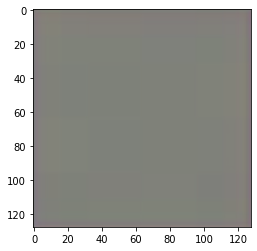

In [145]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [146]:
class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_5 = DBlock(16 * channels, downsample=True, preactivation=True)
    self.res_block_6 = DBlock(16 * channels, downsample=False, preactivation=True)
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)
    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_6(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [147]:
with strategy.scope():
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[-0.11174038]], shape=(1, 1), dtype=float32)


In [148]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [149]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [150]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.999,epsilon=1e-6,)
  discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.0, beta_2=0.999, epsilon=1e-6)

In [151]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(wspace=0.01, hspace=0)

  fig.set_figheight(100)
  fig.set_figwidth(100)
  fig.set_tight_layout(True)
 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')
  plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig)

In [152]:
with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,
  discriminator=discriminator)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
status = checkpoint.restore(latest_checkpoint, options=local_device_option)

if latest_checkpoint:
  first_epoch = int(latest_checkpoint.split(sep='ckpt-')[-1]) * CHECKPOINT_INTERVAL
else:
  first_epoch = 0

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

def save_checkpoint():
  checkpoint_dir = CHECKPOINT_DIR
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(first_epoch, EPOCHS):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch + 1, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % 5 == 0:
    sample_images(epoch)

  if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 1/500


  0%|          | 0/406 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 1024), dtype=float32), dense_shape=Tensor("PartitionedCall_2:65", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % 

Time for epoch 1 is 408.7081413269043 sec
Epoch: 2/500


Current step 812: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=-, gen_loss=1.7]


Time for epoch 2 is 52.82904553413391 sec
Epoch: 3/500


Current step 1218: 100%|██████████| 406/406 [00:52<00:00,  7.72it/s, disc_loss=1.09, gen_loss=0.582]


Time for epoch 3 is 52.586750507354736 sec
Epoch: 4/500


Current step 1624: 100%|██████████| 406/406 [00:53<00:00,  7.65it/s, disc_loss=-, gen_loss=1.71]


Time for epoch 4 is 53.09131979942322 sec
Epoch: 5/500


Current step 2030: 100%|██████████| 406/406 [00:53<00:00,  7.64it/s, disc_loss=-, gen_loss=1.59]


Time for epoch 5 is 53.13350248336792 sec
Epoch: 6/500


Current step 2436: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.119, gen_loss=1.41]


Time for epoch 6 is 71.15864968299866 sec
Epoch: 7/500


Current step 2842: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.152, gen_loss=1.24]


Time for epoch 7 is 52.90724515914917 sec
Epoch: 8/500


Current step 3248: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0767, gen_loss=1.14]


Time for epoch 8 is 52.79105257987976 sec
Epoch: 9/500


Current step 3654: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.349, gen_loss=0.764]


Time for epoch 9 is 52.70933222770691 sec
Epoch: 10/500


Current step 4060: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.214, gen_loss=0.854]


Time for epoch 10 is 52.71729516983032 sec
Epoch: 11/500


Current step 4466: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.0222, gen_loss=1.51]


Time for epoch 11 is 70.86627435684204 sec
Epoch: 12/500


Current step 4872: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=2.2, gen_loss=1.52]


Time for epoch 12 is 52.762569189071655 sec
Epoch: 13/500


Current step 5278: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0003, gen_loss=1.53]


Time for epoch 13 is 52.773308753967285 sec
Epoch: 14/500


Current step 5684: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.0951, gen_loss=1.2]


Time for epoch 14 is 52.978628635406494 sec
Epoch: 15/500


Current step 6090: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.0802, gen_loss=1.31]


Time for epoch 15 is 52.71294569969177 sec
Epoch: 16/500


Current step 6496: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0536, gen_loss=1.42]


Time for epoch 16 is 70.88914632797241 sec
Epoch: 17/500


Current step 6902: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.151, gen_loss=1.12]


Time for epoch 17 is 52.757832765579224 sec
Epoch: 18/500


Current step 7308: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.107, gen_loss=1.42]


Time for epoch 18 is 52.788798570632935 sec
Epoch: 19/500


Current step 7714: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.743, gen_loss=1.58]


Time for epoch 19 is 52.802878856658936 sec
Epoch: 20/500


Current step 8120: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.292, gen_loss=1.06]


Time for epoch 20 is 52.747100830078125 sec
Epoch: 21/500


Current step 8526: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.535, gen_loss=0.969]


Time for epoch 21 is 70.97900366783142 sec
Epoch: 22/500


Current step 8932: 100%|██████████| 406/406 [00:53<00:00,  7.64it/s, disc_loss=0.577, gen_loss=0.801]


Time for epoch 22 is 53.13153553009033 sec
Epoch: 23/500


Current step 9338: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.72, gen_loss=0.824]


Time for epoch 23 is 52.98493027687073 sec
Epoch: 24/500


Current step 9744: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.152, gen_loss=1.83]


Time for epoch 24 is 52.82327485084534 sec
Epoch: 25/500


Current step 10150: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.578, gen_loss=2.17]


Time for epoch 25 is 52.794063329696655 sec
Epoch: 26/500


Current step 10556: 100%|██████████| 406/406 [00:52<00:00,  7.72it/s, disc_loss=0.213, gen_loss=2.42]


Time for epoch 26 is 72.99107480049133 sec
Epoch: 27/500


Current step 10962: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.166, gen_loss=2.76]


Time for epoch 27 is 52.70848321914673 sec
Epoch: 28/500


Current step 11368: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.867, gen_loss=0.438]


Time for epoch 28 is 52.90111708641052 sec
Epoch: 29/500


Current step 11774: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=1.03, gen_loss=0.273]


Time for epoch 29 is 52.86023569107056 sec
Epoch: 30/500


Current step 12180: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.196, gen_loss=2.7]


Time for epoch 30 is 52.667930603027344 sec
Epoch: 31/500


Current step 12586: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.0672, gen_loss=2.23]


Time for epoch 31 is 71.26856732368469 sec
Epoch: 32/500


Current step 12992: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.303, gen_loss=1.6]


Time for epoch 32 is 52.640886545181274 sec
Epoch: 33/500


Current step 13398: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.917, gen_loss=2.78]


Time for epoch 33 is 52.6864972114563 sec
Epoch: 34/500


Current step 13804: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.131, gen_loss=2.76]


Time for epoch 34 is 52.85465621948242 sec
Epoch: 35/500


Current step 14210: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.108, gen_loss=2.1]


Time for epoch 35 is 52.76434373855591 sec
Epoch: 36/500


Current step 14616: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0564, gen_loss=2.58]


Time for epoch 36 is 71.56319212913513 sec
Epoch: 37/500


Current step 15022: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.543, gen_loss=0.906]


Time for epoch 37 is 52.9447124004364 sec
Epoch: 38/500


Current step 15428: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.434, gen_loss=3.45]


Time for epoch 38 is 52.80346131324768 sec
Epoch: 39/500


Current step 15834: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.66, gen_loss=2.87]


Time for epoch 39 is 52.825387716293335 sec
Epoch: 40/500


Current step 16240: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.569, gen_loss=0.922]


Time for epoch 40 is 52.697460651397705 sec
Epoch: 41/500


Current step 16646: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.311, gen_loss=1.98]


Time for epoch 41 is 70.88886284828186 sec
Epoch: 42/500


Current step 17052: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.622, gen_loss=2.92]


Time for epoch 42 is 52.832311153411865 sec
Epoch: 43/500


Current step 17458: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.236, gen_loss=2.58]


Time for epoch 43 is 52.72642517089844 sec
Epoch: 44/500


Current step 17864: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.346, gen_loss=1.79]


Time for epoch 44 is 52.74221444129944 sec
Epoch: 45/500


Current step 18270: 100%|██████████| 406/406 [00:52<00:00,  7.72it/s, disc_loss=0.282, gen_loss=2.26]


Time for epoch 45 is 52.59546518325806 sec
Epoch: 46/500


Current step 18676: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.228, gen_loss=1.82]


Time for epoch 46 is 71.31633687019348 sec
Epoch: 47/500


Current step 19082: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.189, gen_loss=2.25]


Time for epoch 47 is 52.864827394485474 sec
Epoch: 48/500


Current step 19488: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.137, gen_loss=2.21]


Time for epoch 48 is 52.81399869918823 sec
Epoch: 49/500


Current step 19894: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.162, gen_loss=1.68]


Time for epoch 49 is 52.690269231796265 sec
Epoch: 50/500


Current step 20300: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.346, gen_loss=1.64]


Time for epoch 50 is 62.02833557128906 sec
Epoch: 51/500


Current step 20706: 100%|██████████| 406/406 [00:55<00:00,  7.36it/s, disc_loss=1.6, gen_loss=-.463]


Time for epoch 51 is 73.43750190734863 sec
Epoch: 52/500


Current step 21112: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.173, gen_loss=1.65]


Time for epoch 52 is 52.69438862800598 sec
Epoch: 53/500


Current step 21518: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.575, gen_loss=2.95]


Time for epoch 53 is 52.72670817375183 sec
Epoch: 54/500


Current step 21924: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.116, gen_loss=2.61]


Time for epoch 54 is 52.71813488006592 sec
Epoch: 55/500


Current step 22330: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.17, gen_loss=2.63]


Time for epoch 55 is 52.76784873008728 sec
Epoch: 56/500


Current step 22736: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.294, gen_loss=1.51]


Time for epoch 56 is 73.61738991737366 sec
Epoch: 57/500


Current step 23142: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.137, gen_loss=2.38]


Time for epoch 57 is 52.801008462905884 sec
Epoch: 58/500


Current step 23548: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.751, gen_loss=0.898]


Time for epoch 58 is 52.853925466537476 sec
Epoch: 59/500


Current step 23954: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.164, gen_loss=3.22]


Time for epoch 59 is 52.68414783477783 sec
Epoch: 60/500


Current step 24360: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.446, gen_loss=1.18]


Time for epoch 60 is 52.74619770050049 sec
Epoch: 61/500


Current step 24766: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.155, gen_loss=2.21]


Time for epoch 61 is 71.22304177284241 sec
Epoch: 62/500


Current step 25172: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.38, gen_loss=1.81]


Time for epoch 62 is 52.7694456577301 sec
Epoch: 63/500


Current step 25578: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.275, gen_loss=2.3]


Time for epoch 63 is 52.81152939796448 sec
Epoch: 64/500


Current step 25984: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.121, gen_loss=2.9]


Time for epoch 64 is 52.8170702457428 sec
Epoch: 65/500


Current step 26390: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.211, gen_loss=2.61]


Time for epoch 65 is 52.638103008270264 sec
Epoch: 66/500


Current step 26796: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.109, gen_loss=2.53]


Time for epoch 66 is 71.24397897720337 sec
Epoch: 67/500


Current step 27202: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.613, gen_loss=3.55]


Time for epoch 67 is 52.63244962692261 sec
Epoch: 68/500


Current step 27608: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.113, gen_loss=2.25]


Time for epoch 68 is 52.75552797317505 sec
Epoch: 69/500


Current step 28014: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.0703, gen_loss=2.45]


Time for epoch 69 is 52.708577156066895 sec
Epoch: 70/500


Current step 28420: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0682, gen_loss=2.69]


Time for epoch 70 is 52.77883052825928 sec
Epoch: 71/500


Current step 28826: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.151, gen_loss=2.58]


Time for epoch 71 is 71.549720287323 sec
Epoch: 72/500


Current step 29232: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.127, gen_loss=3.55]


Time for epoch 72 is 52.70517683029175 sec
Epoch: 73/500


Current step 29638: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.047, gen_loss=2.89]


Time for epoch 73 is 52.906370639801025 sec
Epoch: 74/500


Current step 30044: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.207, gen_loss=2.17]


Time for epoch 74 is 52.75127339363098 sec
Epoch: 75/500


Current step 30450: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.166, gen_loss=1.72]


Time for epoch 75 is 52.63702988624573 sec
Epoch: 76/500


Current step 30856: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.082, gen_loss=2.56]


Time for epoch 76 is 70.92172503471375 sec
Epoch: 77/500


Current step 31262: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.105, gen_loss=2.87]


Time for epoch 77 is 52.73236966133118 sec
Epoch: 78/500


Current step 31668: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.274, gen_loss=2.21]


Time for epoch 78 is 52.76378631591797 sec
Epoch: 79/500


Current step 32074: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.333, gen_loss=3.53]


Time for epoch 79 is 52.69619393348694 sec
Epoch: 80/500


Current step 32480: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.238, gen_loss=1.91]


Time for epoch 80 is 52.70661902427673 sec
Epoch: 81/500


Current step 32886: 100%|██████████| 406/406 [00:52<00:00,  7.72it/s, disc_loss=0.438, gen_loss=1.22]


Time for epoch 81 is 70.8503909111023 sec
Epoch: 82/500


Current step 33292: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.225, gen_loss=2.1]


Time for epoch 82 is 52.7138786315918 sec
Epoch: 83/500


Current step 33698: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.17, gen_loss=2.63]


Time for epoch 83 is 52.726884841918945 sec
Epoch: 84/500


Current step 34104: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.651, gen_loss=4.24]


Time for epoch 84 is 52.92212629318237 sec
Epoch: 85/500


Current step 34510: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.313, gen_loss=2.89]


Time for epoch 85 is 52.75648474693298 sec
Epoch: 86/500


Current step 34916: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.352, gen_loss=2.08]


Time for epoch 86 is 71.00490880012512 sec
Epoch: 87/500


Current step 35322: 100%|██████████| 406/406 [00:52<00:00,  7.72it/s, disc_loss=0.132, gen_loss=3.04]


Time for epoch 87 is 52.61761522293091 sec
Epoch: 88/500


Current step 35728: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.0828, gen_loss=2.23]


Time for epoch 88 is 52.75964045524597 sec
Epoch: 89/500


Current step 36134: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.171, gen_loss=2.05]


Time for epoch 89 is 52.739163637161255 sec
Epoch: 90/500


Current step 36540: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.323, gen_loss=1.73]


Time for epoch 90 is 52.9441180229187 sec
Epoch: 91/500


Current step 36946: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.338, gen_loss=3.58]


Time for epoch 91 is 74.40772342681885 sec
Epoch: 92/500


Current step 37352: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.146, gen_loss=3.52]


Time for epoch 92 is 52.78265738487244 sec
Epoch: 93/500


Current step 37758: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.137, gen_loss=2.93]


Time for epoch 93 is 52.794511556625366 sec
Epoch: 94/500


Current step 38164: 100%|██████████| 406/406 [00:53<00:00,  7.64it/s, disc_loss=0.111, gen_loss=2.71]


Time for epoch 94 is 53.148462533950806 sec
Epoch: 95/500


Current step 38570: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.108, gen_loss=2.92]


Time for epoch 95 is 52.760040283203125 sec
Epoch: 96/500


Current step 38976: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.342, gen_loss=1.58]


Time for epoch 96 is 71.37771558761597 sec
Epoch: 97/500


Current step 39382: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.218, gen_loss=2]


Time for epoch 97 is 52.68593764305115 sec
Epoch: 98/500


Current step 39788: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.688, gen_loss=3.49]


Time for epoch 98 is 52.684000730514526 sec
Epoch: 99/500


Current step 40194: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.179, gen_loss=3.33]


Time for epoch 99 is 52.703673124313354 sec
Epoch: 100/500


Current step 40600: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.143, gen_loss=2.02]


Time for epoch 100 is 62.179701805114746 sec
Epoch: 101/500


Current step 41006: 100%|██████████| 406/406 [00:54<00:00,  7.39it/s, disc_loss=0.0763, gen_loss=2.55]


Time for epoch 101 is 73.60779571533203 sec
Epoch: 102/500


Current step 41412: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.185, gen_loss=3.35]


Time for epoch 102 is 52.8343780040741 sec
Epoch: 103/500


Current step 41818: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.155, gen_loss=2.31]


Time for epoch 103 is 52.88039040565491 sec
Epoch: 104/500


Current step 42224: 100%|██████████| 406/406 [00:53<00:00,  7.65it/s, disc_loss=0.194, gen_loss=3.03]


Time for epoch 104 is 53.088964223861694 sec
Epoch: 105/500


Current step 42630: 100%|██████████| 406/406 [00:53<00:00,  7.66it/s, disc_loss=0.323, gen_loss=2.79]


Time for epoch 105 is 53.037078619003296 sec
Epoch: 106/500


Current step 43036: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=1.21, gen_loss=4.02]


Time for epoch 106 is 71.58375144004822 sec
Epoch: 107/500


Current step 43442: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.448, gen_loss=3.04]


Time for epoch 107 is 52.79458022117615 sec
Epoch: 108/500


Current step 43848: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.121, gen_loss=3.27]


Time for epoch 108 is 52.75067663192749 sec
Epoch: 109/500


Current step 44254: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.247, gen_loss=3.12]


Time for epoch 109 is 52.77616238594055 sec
Epoch: 110/500


Current step 44660: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0885, gen_loss=3.2]


Time for epoch 110 is 52.82379341125488 sec
Epoch: 111/500


Current step 45066: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.144, gen_loss=2.65]


Time for epoch 111 is 71.54561567306519 sec
Epoch: 112/500


Current step 45472: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.191, gen_loss=3.01]


Time for epoch 112 is 52.827858686447144 sec
Epoch: 113/500


Current step 45878: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.156, gen_loss=2]


Time for epoch 113 is 52.81402778625488 sec
Epoch: 114/500


Current step 46284: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.424, gen_loss=1.31]


Time for epoch 114 is 52.88590979576111 sec
Epoch: 115/500


Current step 46690: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.535, gen_loss=1.21]


Time for epoch 115 is 52.80455493927002 sec
Epoch: 116/500


Current step 47096: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0949, gen_loss=2.73]


Time for epoch 116 is 71.71198558807373 sec
Epoch: 117/500


Current step 47502: 100%|██████████| 406/406 [00:53<00:00,  7.65it/s, disc_loss=0.0184, gen_loss=3.23]


Time for epoch 117 is 53.07946562767029 sec
Epoch: 118/500


Current step 47908: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.271, gen_loss=2.42]


Time for epoch 118 is 52.97445583343506 sec
Epoch: 119/500


Current step 48314: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.248, gen_loss=3.69]


Time for epoch 119 is 52.85162377357483 sec
Epoch: 120/500


Current step 48720: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.344, gen_loss=1.81]


Time for epoch 120 is 52.82695460319519 sec
Epoch: 121/500


Current step 49126: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.171, gen_loss=2.87]


Time for epoch 121 is 72.1710855960846 sec
Epoch: 122/500


Current step 49532: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.074, gen_loss=2.62]


Time for epoch 122 is 52.808645486831665 sec
Epoch: 123/500


Current step 49938: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.116, gen_loss=3.79]


Time for epoch 123 is 52.844537019729614 sec
Epoch: 124/500


Current step 50344: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0932, gen_loss=3.02]


Time for epoch 124 is 52.85919690132141 sec
Epoch: 125/500


Current step 50750: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.0831, gen_loss=3.09]


Time for epoch 125 is 52.93065524101257 sec
Epoch: 126/500


Current step 51156: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.412, gen_loss=1.27]


Time for epoch 126 is 71.62949228286743 sec
Epoch: 127/500


Current step 51562: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.262, gen_loss=2.03]


Time for epoch 127 is 52.80514717102051 sec
Epoch: 128/500


Current step 51968: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.227, gen_loss=3.77]


Time for epoch 128 is 52.85076975822449 sec
Epoch: 129/500


Current step 52374: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.143, gen_loss=2.38]


Time for epoch 129 is 52.915934801101685 sec
Epoch: 130/500


Current step 52780: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.239, gen_loss=2.47]


Time for epoch 130 is 52.86515164375305 sec
Epoch: 131/500


Current step 53186: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.564, gen_loss=1.33]


Time for epoch 131 is 71.57300353050232 sec
Epoch: 132/500


Current step 53592: 100%|██████████| 406/406 [00:53<00:00,  7.65it/s, disc_loss=0.227, gen_loss=2.2]


Time for epoch 132 is 53.06391191482544 sec
Epoch: 133/500


Current step 53998: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.088, gen_loss=3.29]


Time for epoch 133 is 52.847981691360474 sec
Epoch: 134/500


Current step 54404: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.105, gen_loss=2.6]


Time for epoch 134 is 52.81048941612244 sec
Epoch: 135/500


Current step 54810: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0608, gen_loss=2.29]


Time for epoch 135 is 52.87549352645874 sec
Epoch: 136/500


Current step 55216: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.226, gen_loss=2.6]


Time for epoch 136 is 75.84775376319885 sec
Epoch: 137/500


Current step 55622: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.173, gen_loss=1.95]


Time for epoch 137 is 52.79729604721069 sec
Epoch: 138/500


Current step 56028: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0295, gen_loss=3.02]


Time for epoch 138 is 52.86070251464844 sec
Epoch: 139/500


Current step 56434: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.121, gen_loss=2.69]


Time for epoch 139 is 52.864928245544434 sec
Epoch: 140/500


Current step 56840: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.28, gen_loss=2.11]


Time for epoch 140 is 52.721415281295776 sec
Epoch: 141/500


Current step 57246: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.177, gen_loss=2.75]


Time for epoch 141 is 72.45888805389404 sec
Epoch: 142/500


Current step 57652: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.319, gen_loss=2.22]


Time for epoch 142 is 52.766003370285034 sec
Epoch: 143/500


Current step 58058: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.225, gen_loss=2.46]


Time for epoch 143 is 52.713677644729614 sec
Epoch: 144/500


Current step 58464: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.168, gen_loss=3.31]


Time for epoch 144 is 52.90829062461853 sec
Epoch: 145/500


Current step 58870: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.171, gen_loss=2.08]


Time for epoch 145 is 52.771416664123535 sec
Epoch: 146/500


Current step 59276: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.176, gen_loss=2.52]


Time for epoch 146 is 71.31730341911316 sec
Epoch: 147/500


Current step 59682: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.188, gen_loss=2.62]


Time for epoch 147 is 52.86495757102966 sec
Epoch: 148/500


Current step 60088: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.141, gen_loss=3.01]


Time for epoch 148 is 52.77675819396973 sec
Epoch: 149/500


Current step 60494: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.0817, gen_loss=3.03]


Time for epoch 149 is 52.942694664001465 sec
Epoch: 150/500


Current step 60900: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.161, gen_loss=2.57]


Time for epoch 150 is 63.33504295349121 sec
Epoch: 151/500


Current step 61306: 100%|██████████| 406/406 [00:53<00:00,  7.56it/s, disc_loss=0.0643, gen_loss=3.37]


Time for epoch 151 is 71.71041965484619 sec
Epoch: 152/500


Current step 61712: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.269, gen_loss=3.23]


Time for epoch 152 is 52.85375785827637 sec
Epoch: 153/500


Current step 62118: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.0952, gen_loss=2.51]


Time for epoch 153 is 52.735934019088745 sec
Epoch: 154/500


Current step 62524: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.144, gen_loss=2.69]


Time for epoch 154 is 52.70864939689636 sec
Epoch: 155/500


Current step 62930: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.262, gen_loss=2.16]


Time for epoch 155 is 52.90451240539551 sec
Epoch: 156/500


Current step 63336: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.385, gen_loss=1.97]


Time for epoch 156 is 71.34500193595886 sec
Epoch: 157/500


Current step 63742: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.929, gen_loss=4.08]


Time for epoch 157 is 52.79667329788208 sec
Epoch: 158/500


Current step 64148: 100%|██████████| 406/406 [00:53<00:00,  7.64it/s, disc_loss=0.162, gen_loss=2.33]


Time for epoch 158 is 53.15732192993164 sec
Epoch: 159/500


Current step 64554: 100%|██████████| 406/406 [00:53<00:00,  7.62it/s, disc_loss=0.159, gen_loss=3.26]


Time for epoch 159 is 53.30683183670044 sec
Epoch: 160/500


Current step 64960: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.118, gen_loss=2.31]


Time for epoch 160 is 52.862372398376465 sec
Epoch: 161/500


Current step 65366: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.151, gen_loss=2.66]


Time for epoch 161 is 71.58368873596191 sec
Epoch: 162/500


Current step 65772: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.33, gen_loss=2.09]


Time for epoch 162 is 52.83866786956787 sec
Epoch: 163/500


Current step 66178: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.158, gen_loss=2.52]


Time for epoch 163 is 52.90343928337097 sec
Epoch: 164/500


Current step 66584: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.422, gen_loss=1.52]


Time for epoch 164 is 52.89038920402527 sec
Epoch: 165/500


Current step 66990: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.277, gen_loss=2.23]


Time for epoch 165 is 52.77841639518738 sec
Epoch: 166/500


Current step 67396: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.21, gen_loss=2.55]


Time for epoch 166 is 71.3676962852478 sec
Epoch: 167/500


Current step 67802: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.0734, gen_loss=2.77]


Time for epoch 167 is 52.98743772506714 sec
Epoch: 168/500


Current step 68208: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.209, gen_loss=2.5]


Time for epoch 168 is 52.84370183944702 sec
Epoch: 169/500


Current step 68614: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.225, gen_loss=1.97]


Time for epoch 169 is 52.80257320404053 sec
Epoch: 170/500


Current step 69020: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.188, gen_loss=2.19]


Time for epoch 170 is 52.76699662208557 sec
Epoch: 171/500


Current step 69426: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.446, gen_loss=3.35]


Time for epoch 171 is 71.67644190788269 sec
Epoch: 172/500


Current step 69832: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.136, gen_loss=2.75]


Time for epoch 172 is 52.84249997138977 sec
Epoch: 173/500


Current step 70238: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.424, gen_loss=1.56]


Time for epoch 173 is 52.80303406715393 sec
Epoch: 174/500


Current step 70644: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.185, gen_loss=2.37]


Time for epoch 174 is 52.7629599571228 sec
Epoch: 175/500


Current step 71050: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.319, gen_loss=2.74]


Time for epoch 175 is 52.6589035987854 sec
Epoch: 176/500


Current step 71456: 100%|██████████| 406/406 [00:53<00:00,  7.64it/s, disc_loss=0.282, gen_loss=1.57]


Time for epoch 176 is 71.7386167049408 sec
Epoch: 177/500


Current step 71862: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.137, gen_loss=2.25]


Time for epoch 177 is 52.900577783584595 sec
Epoch: 178/500


Current step 72268: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.219, gen_loss=1.61]


Time for epoch 178 is 52.726131200790405 sec
Epoch: 179/500


Current step 72674: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.156, gen_loss=2.13]


Time for epoch 179 is 52.831175565719604 sec
Epoch: 180/500


Current step 73080: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.225, gen_loss=1.95]


Time for epoch 180 is 52.907613039016724 sec
Epoch: 181/500


Current step 73486: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.219, gen_loss=2.05]


Time for epoch 181 is 71.52397537231445 sec
Epoch: 182/500


Current step 73892: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.112, gen_loss=2.76]


Time for epoch 182 is 52.95686888694763 sec
Epoch: 183/500


Current step 74298: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.138, gen_loss=2.12]


Time for epoch 183 is 52.823455810546875 sec
Epoch: 184/500


Current step 74704: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.126, gen_loss=2.99]


Time for epoch 184 is 52.72406458854675 sec
Epoch: 185/500


Current step 75110: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0787, gen_loss=3.35]


Time for epoch 185 is 52.79569149017334 sec
Epoch: 186/500


Current step 75516: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.292, gen_loss=1.85]


Time for epoch 186 is 71.47194147109985 sec
Epoch: 187/500


Current step 75922: 100%|██████████| 406/406 [00:52<00:00,  7.66it/s, disc_loss=0.106, gen_loss=2.45]


Time for epoch 187 is 52.98465323448181 sec
Epoch: 188/500


Current step 76328: 100%|██████████| 406/406 [00:53<00:00,  7.65it/s, disc_loss=0.406, gen_loss=3.19]


Time for epoch 188 is 53.048665046691895 sec
Epoch: 189/500


Current step 76734: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.145, gen_loss=3.32]


Time for epoch 189 is 52.97260308265686 sec
Epoch: 190/500


Current step 77140: 100%|██████████| 406/406 [00:53<00:00,  7.66it/s, disc_loss=0.264, gen_loss=1.83]


Time for epoch 190 is 53.01068425178528 sec
Epoch: 191/500


Current step 77546: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.458, gen_loss=1.49]


Time for epoch 191 is 71.30042266845703 sec
Epoch: 192/500


Current step 77952: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0811, gen_loss=3.03]


Time for epoch 192 is 52.86506009101868 sec
Epoch: 193/500


Current step 78358: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.273, gen_loss=1.79]


Time for epoch 193 is 52.83882141113281 sec
Epoch: 194/500


Current step 78764: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.118, gen_loss=2.19]


Time for epoch 194 is 52.82498741149902 sec
Epoch: 195/500


Current step 79170: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.135, gen_loss=2.42]


Time for epoch 195 is 52.84122824668884 sec
Epoch: 196/500


Current step 79576: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.402, gen_loss=2.48]


Time for epoch 196 is 76.83812212944031 sec
Epoch: 197/500


Current step 79982: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.101, gen_loss=2.56]


Time for epoch 197 is 52.84704041481018 sec
Epoch: 198/500


Current step 80388: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.148, gen_loss=2.65]


Time for epoch 198 is 52.94236373901367 sec
Epoch: 199/500


Current step 80794: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.169, gen_loss=3.09]


Time for epoch 199 is 52.75273633003235 sec
Epoch: 200/500


Current step 81200: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.126, gen_loss=2.87]


Time for epoch 200 is 61.4540011882782 sec
Epoch: 201/500


Current step 81606: 100%|██████████| 406/406 [00:54<00:00,  7.44it/s, disc_loss=0.315, gen_loss=1.8]


Time for epoch 201 is 72.66064405441284 sec
Epoch: 202/500


Current step 82012: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.173, gen_loss=2.88]


Time for epoch 202 is 52.872424840927124 sec
Epoch: 203/500


Current step 82418: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.262, gen_loss=3.52]


Time for epoch 203 is 52.74534797668457 sec
Epoch: 204/500


Current step 82824: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.694, gen_loss=4.3]


Time for epoch 204 is 52.87430715560913 sec
Epoch: 205/500


Current step 83230: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.155, gen_loss=2.45]


Time for epoch 205 is 52.78736925125122 sec
Epoch: 206/500


Current step 83636: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.531, gen_loss=1.29]


Time for epoch 206 is 71.21104669570923 sec
Epoch: 207/500


Current step 84042: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.216, gen_loss=2.7]


Time for epoch 207 is 52.75806164741516 sec
Epoch: 208/500


Current step 84448: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0996, gen_loss=2.76]


Time for epoch 208 is 52.8453905582428 sec
Epoch: 209/500


Current step 84854: 100%|██████████| 406/406 [00:52<00:00,  7.67it/s, disc_loss=0.298, gen_loss=1.78]


Time for epoch 209 is 52.94602155685425 sec
Epoch: 210/500


Current step 85260: 100%|██████████| 406/406 [00:52<00:00,  7.71it/s, disc_loss=0.251, gen_loss=2.01]


Time for epoch 210 is 52.685118675231934 sec
Epoch: 211/500


Current step 85666: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.237, gen_loss=2.48]


Time for epoch 211 is 71.50811195373535 sec
Epoch: 212/500


Current step 86072: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.0904, gen_loss=2.58]


Time for epoch 212 is 52.84562587738037 sec
Epoch: 213/500


Current step 86478: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.439, gen_loss=1.53]


Time for epoch 213 is 52.831833600997925 sec
Epoch: 214/500


Current step 86884: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.291, gen_loss=2.15]


Time for epoch 214 is 52.806299448013306 sec
Epoch: 215/500


Current step 87290: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.204, gen_loss=2.04]


Time for epoch 215 is 52.87883424758911 sec
Epoch: 216/500


Current step 87696: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.455, gen_loss=4.01]


Time for epoch 216 is 71.22770309448242 sec
Epoch: 217/500


Current step 88102: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.139, gen_loss=3.4]


Time for epoch 217 is 52.78400492668152 sec
Epoch: 218/500


Current step 88508: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.312, gen_loss=1.85]


Time for epoch 218 is 52.74792671203613 sec
Epoch: 219/500


Current step 88914: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.197, gen_loss=1.96]


Time for epoch 219 is 52.90250825881958 sec
Epoch: 220/500


Current step 89320: 100%|██████████| 406/406 [00:52<00:00,  7.70it/s, disc_loss=0.227, gen_loss=2.34]


Time for epoch 220 is 52.70582389831543 sec
Epoch: 221/500


Current step 89726: 100%|██████████| 406/406 [00:52<00:00,  7.68it/s, disc_loss=0.307, gen_loss=2.94]


Time for epoch 221 is 71.20790028572083 sec
Epoch: 222/500


Current step 90132: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, disc_loss=0.0644, gen_loss=2.92]


Time for epoch 222 is 52.77933955192566 sec
Epoch: 223/500


Current step 90174:  10%|█         | 42/406 [00:05<00:48,  7.54it/s, disc_loss=0.186, gen_loss=2.61]


KeyboardInterrupt: ignored